# Multi-objective optimization with Expected HyperVolume Improvement

In [1]:
import math

import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from util.plotting import (
    plot_bo_points,
    plot_function_2d,
    plot_mobo_history,
    plot_mobo_points_in_obj_space,
)

In [2]:
import trieste
from trieste.acquisition.function import ExpectedHypervolumeImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.data import Dataset
from trieste.models import create_model, TrainableModelStack
from trieste.models.gpflow.models import GaussianProcessRegression
from trieste.space import Box
from trieste.objectives.multi_objectives import VLMOP2
from trieste.acquisition.multi_objective.pareto import (
    Pareto,
    get_reference_point,
)

np.random.seed(1793)
tf.random.set_seed(1793)

## Describe the problem

In this tutorial, we provide a multi-objective optimization example using the expected hypervolume improvement acquisition function.
We consider the VLMOP2 function --- a synthetic benchmark problem with two objectives. We start by defining the problem parameters.

In [3]:
vlmop2 = VLMOP2().objective()
observer = trieste.objectives.utils.mk_observer(vlmop2)

In [4]:
mins = [-2, -2]
maxs = [2, 2]
search_space = Box(mins, maxs)
num_objective = 2

Let's randomly sample some initial data from the observer ...

In [5]:
num_initial_points = 20
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

... and visualise the data across the design space: each figure contains the contour lines of each objective function.

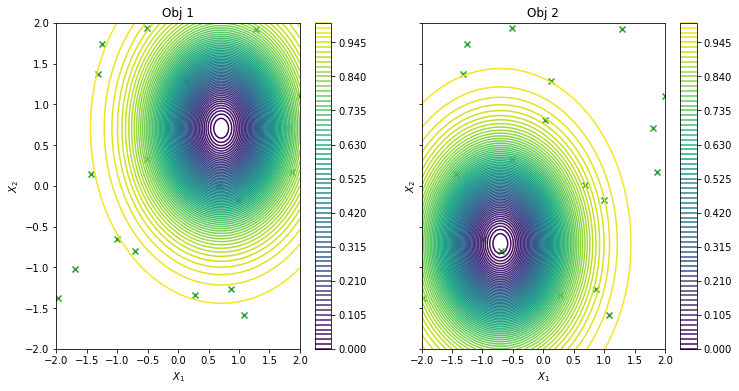

In [6]:
_, ax = plot_function_2d(
    vlmop2,
    mins,
    maxs,
    grid_density=100,
    contour=True,
    title=["Obj 1", "Obj 2"],
    figsize=(12, 6),
    colorbar=True,
    xlabel="$X_1$",
    ylabel="$X_2$",
)
plot_bo_points(initial_query_points, ax=ax[0, 0], num_init=num_initial_points)
plot_bo_points(initial_query_points, ax=ax[0, 1], num_init=num_initial_points)
plt.show()

... and in the objective space. The `plot_mobo_points_in_obj_space` will automatically search for non-dominated points and colours them in purple.

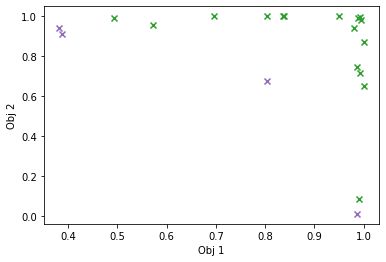

In [7]:
plot_mobo_points_in_obj_space(initial_data.observations)
plt.show()

## Modelling the two functions

In this example we model the two objective functions individually with their own Gaussian process models, for problems where the objective functions are similar it may make sense to build a joint model.

We use a model wrapper: `TrainableModelStack` to stack these two independent GPs into a single model working as an (independent) multi-output model.

In [8]:
def build_stacked_independent_objectives_model(
    data: Dataset, num_output
) -> TrainableModelStack:
    gprs = []
    for idx in range(num_output):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        variance = tf.math.reduce_variance(single_obj_data.observations)
        kernel = gpflow.kernels.Matern52(variance)
        gpr = gpflow.models.GPR(
            (single_obj_data.query_points, single_obj_data.observations),
            kernel,
            noise_variance=1e-5,
        )
        gpflow.utilities.set_trainable(gpr.likelihood, False)
        gprs.append((GaussianProcessRegression(gpr), 1))

    return TrainableModelStack(*gprs)

In [9]:
model = build_stacked_independent_objectives_model(initial_data, num_objective)

## Define the acquisition function
Here we utilize the [EHVI](https://link.springer.com/article/10.1007/s10898-019-00798-7): `ExpectedHypervolumeImprovement` acquisition function:

In [10]:
ehvi = ExpectedHypervolumeImprovement()
rule: EfficientGlobalOptimization = EfficientGlobalOptimization(builder=ehvi)

## Run the optimization loop

We can now run the optimization loop

In [11]:
num_steps = 30
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
result = bo.optimize(num_steps, initial_data, model, acquisition_rule=rule)

Optimization completed without errors


To conclude, we visualize the queried data across the design space.
We represent the initial points as crosses and the points obtained by our optimization loop as dots.

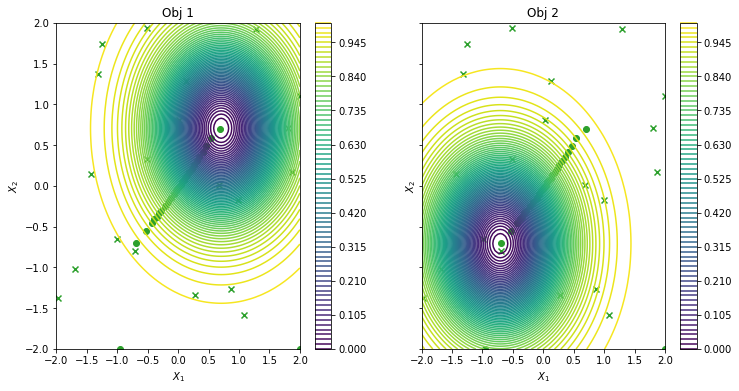

In [12]:
dataset = result.try_get_final_dataset()
data_query_points = dataset.query_points
data_observations = dataset.observations

_, ax = plot_function_2d(
    vlmop2,
    mins,
    maxs,
    grid_density=100,
    contour=True,
    figsize=(12, 6),
    title=["Obj 1", "Obj 2"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    colorbar=True,
)
plot_bo_points(data_query_points, ax=ax[0, 0], num_init=num_initial_points)
plot_bo_points(data_query_points, ax=ax[0, 1], num_init=num_initial_points)
plt.show()

Visualize in objective space. Purple dots denote the non-dominated points.

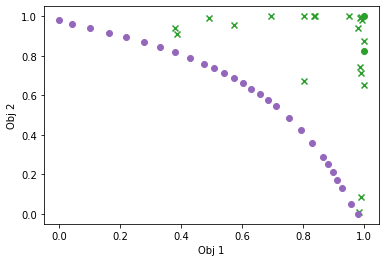

In [13]:
plot_mobo_points_in_obj_space(data_observations, num_init=num_initial_points)
plt.show()

We can also visualize how a performance metric evolved with respect to the number of BO iterations.
First, we need to define a performance metric. Many metrics have been considered for multi-objective optimization. Here, we use the log hypervolume difference, defined as the difference between the hypervolume of the actual Pareto front and the hypervolume of the approximate Pareto front based on the bo-obtained data.


$$
log_{10}\ \text{HV}_{\text{diff}} = log_{10}(\text{HV}_{\text{actual}} - \text{HV}_{\text{bo-obtained}})
$$


First we need to calculate the $\text{HV}_{\text{actual}}$ based on the actual Pareto front. For some multi-objective synthetic functions like VLMOP2, the actual Pareto front has a clear definition, thus we could use `gen_pareto_optimal_points` to near uniformly sample on the actual Pareto front. And use these generated Pareto optimal points to (approximately) calculate the hypervolume of the actual Pareto frontier:

In [14]:
actual_pf = VLMOP2().gen_pareto_optimal_points(100)  # gen 100 pf points
ref_point = get_reference_point(data_observations)
idea_hv = Pareto(
    tf.cast(actual_pf, dtype=data_observations.dtype)
).hypervolume_indicator(ref_point)

Then we define the metric function:

In [15]:
def log_hv(observations):
    obs_hv = Pareto(observations).hypervolume_indicator(ref_point)
    return math.log10(idea_hv - obs_hv)

Finally, we can plot the convergence of our performance metric over the course of the optimization.
The blue vertical line in the figure denotes the time after which BO starts.

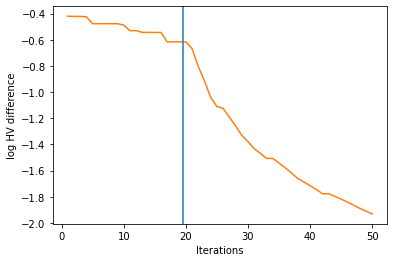

In [16]:
fig, ax = plot_mobo_history(
    data_observations, log_hv, num_init=num_initial_points
)
ax.set_xlabel("Iterations")
ax.set_ylabel("log HV difference")
plt.show()

## Batch multi-objective optimization

EHVI can be extended to the case of batches (i.e. query several points at a time) using the `Fantasizer`. `Fantasizer` works by greedily optimising a base acquisition function, then "fantasizing" the observations at the chosen query points and updating the predictive equations of the models as if the fantasized data was added to the models. The only changes that need to be done here are to wrap the `ExpectedHypervolumeImprovement` in a `Fantasizer` object, and set the rule argument `num_query_points` to a value greater than one. Here, we choose 10 batches of size 3, so the observation budget is the same as before.

In [17]:
model = build_stacked_independent_objectives_model(initial_data, num_objective)

from trieste.acquisition.function import Fantasizer

batch_ehvi = Fantasizer(ExpectedHypervolumeImprovement())
batch_rule: EfficientGlobalOptimization = EfficientGlobalOptimization(
    builder=batch_ehvi, num_query_points=3
)
num_steps = 10
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
batch_result = bo.optimize(
    num_steps, initial_data, model, acquisition_rule=batch_rule
)

Optimization completed without errors


We can have a look at the results, as in the previous case. For this relatively simple problem, the greedy heuristic works quite well, and the performance is similar to the non-batch run.

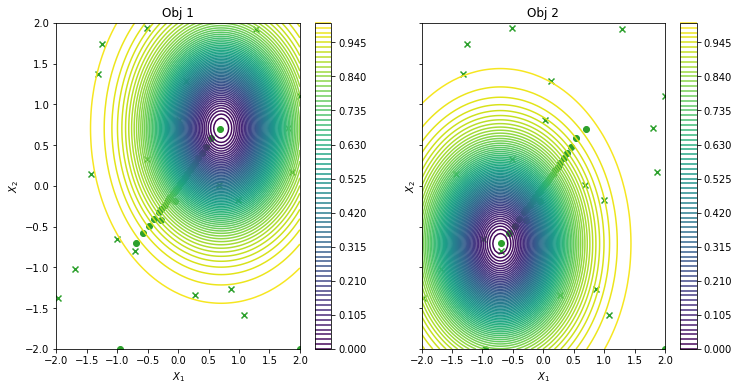

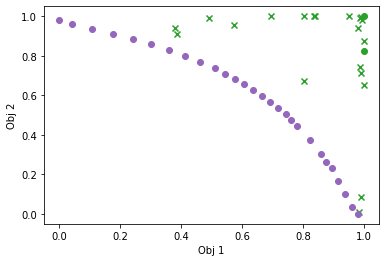

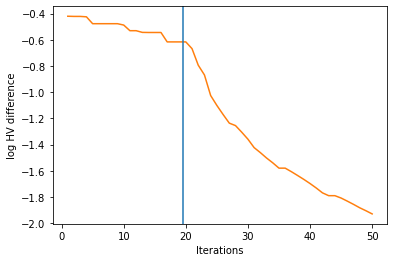

In [18]:

dataset = batch_result.try_get_final_dataset()
batch_data_query_points = dataset.query_points
batch_data_observations = dataset.observations

_, ax = plot_function_2d(
    vlmop2,
    mins,
    maxs,
    grid_density=100,
    contour=True,
    figsize=(12, 6),
    title=["Obj 1", "Obj 2"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    colorbar=True,
)
plot_bo_points(
    batch_data_query_points, ax=ax[0, 0], num_init=num_initial_points
)
plot_bo_points(
    batch_data_query_points, ax=ax[0, 1], num_init=num_initial_points
)
plt.show()

plot_mobo_points_in_obj_space(
    batch_data_observations, num_init=num_initial_points
)
plt.show()

fig, ax = plot_mobo_history(
    batch_data_observations, log_hv, num_init=num_initial_points
)
ax.set_xlabel("Iterations")
ax.set_ylabel("log HV difference")
plt.show()

## Multi-objective optimization with constraints

EHVI can be adapted to the case of constraints, as we show below. We start by defining a problem with the same objectives as above, but with an inequality constraint, and we define the corresponding `Observer`.

In [19]:
class Sim:
    threshold = 0.75

    @staticmethod
    def objective(input_data):
        return vlmop2(input_data)

    @staticmethod
    def constraint(input_data):
        x, y = input_data[:, -2], input_data[:, -1]
        z = tf.cos(x) * tf.cos(y) - tf.sin(x) * tf.sin(y)
        return z[:, None]


OBJECTIVE = "OBJECTIVE"
CONSTRAINT = "CONSTRAINT"


def observer_cst(query_points):
    return {
        OBJECTIVE: Dataset(query_points, Sim.objective(query_points)),
        CONSTRAINT: Dataset(query_points, Sim.constraint(query_points)),
    }


num_initial_points = 10
initial_query_points = search_space.sample(num_initial_points)
initial_data_with_cst = observer_cst(initial_query_points)

As previously, we visualise the data across the design space: each figure contains the contour lines of each objective function and in the objective space. The `plot_mobo_points_in_obj_space` will automatically search for non-dominated points and colours them in purple, and the points in red violate the constraint.

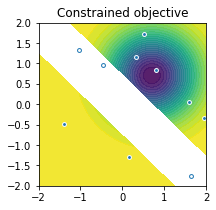

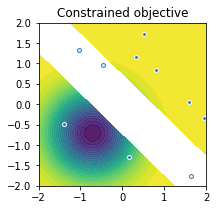

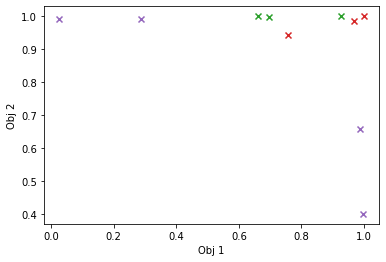

In [20]:
from util.inequality_constraints_utils import plot_2obj_cst_query_points

plot_2obj_cst_query_points(
    search_space,
    Sim,
    initial_data_with_cst[OBJECTIVE].astuple(),
    initial_data_with_cst[CONSTRAINT].astuple(),
)
plt.show()

mask_fail = (
    initial_data_with_cst[CONSTRAINT].observations.numpy() > Sim.threshold
)
plot_mobo_points_in_obj_space(
    initial_data_with_cst[OBJECTIVE].observations, mask_fail=mask_fail[:, 0]
)
plt.show()

We use the same model wrapper to build and stack the two GP models of the objective:

In [21]:
objective_model = build_stacked_independent_objectives_model(
    initial_data_with_cst[OBJECTIVE], num_objective
)

We also create a single model of the constraint:

In [22]:
def create_constraint_model(data):
    variance = tf.math.reduce_variance(data.observations)
    lengthscale = 1.0 * np.ones(2, dtype=gpflow.default_float())
    kernel = gpflow.kernels.Matern52(
        variance=variance, lengthscales=lengthscale
    )
    jitter = gpflow.kernels.White(1e-12)
    gpr = gpflow.models.GPR(
        data.astuple(), kernel + jitter, noise_variance=1e-5
    )
    gpflow.set_trainable(gpr.likelihood, False)
    return GaussianProcessRegression(gpr)


constraint_model = create_constraint_model(initial_data_with_cst[CONSTRAINT])

We store both sets of models in a dictionary:

In [23]:
models = {OBJECTIVE: objective_model, CONSTRAINT: constraint_model}

## Acquisition function for multiple objectives and constraints
We utilize the `ExpectedConstrainedHypervolumeImprovement` acquisition function, which is the product of EHVI (based on the feasible Pareto set) with the probability of feasibility:

In [24]:
from trieste.acquisition.function import (
    ExpectedConstrainedHypervolumeImprovement,
)

pof = trieste.acquisition.ProbabilityOfFeasibility(threshold=Sim.threshold)
echvi = ExpectedConstrainedHypervolumeImprovement(
    OBJECTIVE, pof.using(CONSTRAINT)
)
rule = EfficientGlobalOptimization(builder=echvi)

We can now run the optimization loop

In [25]:
num_steps = 30
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer_cst, search_space)
result = bo.optimize(
    num_steps, initial_data_with_cst, models, acquisition_rule=rule
)

Optimization completed without errors


As previously, we visualize the queried data across the design space.
We represent the initial points as crosses and the points obtained by our optimization loop as dots.

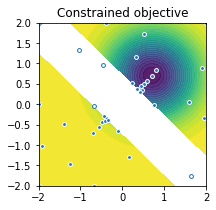

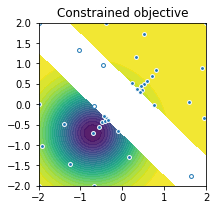

In [26]:
objective_dataset = result.final_result.unwrap().datasets[OBJECTIVE]
constraint_dataset = result.final_result.unwrap().datasets[CONSTRAINT]
data_query_points = objective_dataset.query_points
data_observations = objective_dataset.observations

plot_2obj_cst_query_points(
    search_space,
    Sim,
    objective_dataset.astuple(),
    constraint_dataset.astuple(),
)
plt.show()

Finally, we visualize them in the objective space. Purple dots denote the non-dominated points, and red ones the points that violate the constraint.

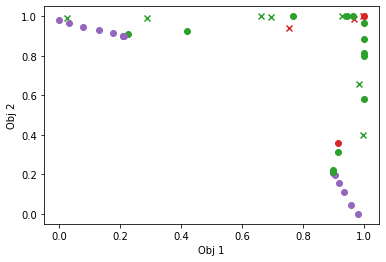

In [27]:
mask_fail = constraint_dataset.observations.numpy() > Sim.threshold
plot_mobo_points_in_obj_space(
    data_observations, num_init=num_initial_points, mask_fail=mask_fail[:, 0]
)
plt.show()

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)